In [21]:
import random
import helpers
import numpy as np
import pandas as pd
from copy import copy
from genetic import Experiment,Population,Chromosome,Gen
from joblib import Parallel, delayed,parallel_backend
import time
from ExperimentBase import ExperimentBaseModel,Transformer,CAModel
from Visualization import Visualization
import matplotlib.pyplot as plt
import math

In [22]:
class Experiment1(ExperimentBaseModel):
    def __init__(self,data,name,path,verbose):
        ExperimentBaseModel.__init__(self,data,name,path,verbose)
    
    def setupChromosome(self,chromosome,goal):
        keys = list(self.domain.keys())
        keys = sorted(keys)
        for key in keys:
            noChoices = random.randint(1,len(self.domain[key])//2)
            vals = set(random.choices(self.domain[key],k=noChoices))
            chromosome.genes.append(Gen(key,vals))
    
    def mutate(self,chromosome):
        if random.random() < self.mutationRate:
            index = random.randint(0,len(chromosome.genes)-1)
            identifier = chromosome.genes[index].identifier
            proportion =  len(self.domain[identifier]) - len(chromosome.genes[index].value)
            if proportion < random.random():
                val = random.choice(self.domain[identifier])
                chromosome.genes[index].value.add(val)
            else:
                if len(chromosome.genes[index].value) > 0:
                    el = random.choice(list(chromosome.genes[index].value))
                    chromosome.genes[index].value.remove(el)
    
    def crossover(self,parent1,parent2,population):
        setup = lambda x: self.setupChromosome(x,population.goal)
        crossover = lambda p1,p2: self.crossover(p1,p2,population)
        chromosome1 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome2 = Chromosome(setup,self.express,crossover,self.mutate,population.generation)
        chromosome1.parents = [parent1,parent2]
        chromosome2.parents = [parent1,parent2]
        iGenes = list(range(len(parent1.genes)))#list(self.domain.keys())
        random.shuffle(iGenes)
        mid = len(iGenes)//2
        genes1 = [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[:mid]]
        genes1 += [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[mid:]]
        chromosome1.genes = sorted(genes1,key=lambda x: x.identifier)
        genes2 = [Gen(parent2.genes[x].identifier,copy(parent2.genes[x].value)) for x in iGenes[:mid]]
        genes2 += [Gen(parent1.genes[x].identifier,copy(parent1.genes[x].value)) for x in iGenes[mid:]]
        chromosome2.genes = sorted(genes2,key=lambda x: x.identifier)
        return [chromosome1,chromosome2]
    
    def express(self,chromosome):
        rule = "lambda x: sum(["
        terms = []
        notZero = 0
        for gen in chromosome.genes:
            vals = gen.value.difference(set([-1]))
            if len(vals) > 0 :
                notZero += 1
                terms.append(f"(x[{gen.identifier}] in {vals} if x[{gen.identifier}] != -1 else 0)")
        if (len(terms) > 0):
            rule += " , ".join(terms) + "]) / {}".format(notZero if notZero > 0 else 100000)
        else:
            rule = "lambda x: 0"
        return rule
    
    def getTotalMatch(self,phenotype,goal):
        totalPosMatch = 0
        totalNegMatch = 0
        totalNeg = 0
        totalPos = 0
        matchProportion = eval(phenotype)
        for row in self.matrix:
            res = matchProportion(row[0])
            if row[2] == goal:
                totalPosMatch += res * row[1]
                totalPos += row[1]
            else:
                totalNegMatch -= res * row[1]
                totalNeg += row[1]
        totalExamples = totalNeg+totalPos
        posProp = (totalPos/totalExamples)
        negProp = (totalNeg/totalExamples)
        total = (totalPosMatch * negProp) + (totalNegMatch * posProp)
        maxTotal = (totalPos * negProp)
        return total/maxTotal
    
    def regulation(self,population):
        population.chromosomes = sorted(population.chromosomes,key = lambda x:x.fitness,reverse = True)
        mid = self.noChromosomes // 2
        indexes = [x for x in range(1,len(population.chromosomes))]
        random.shuffle(indexes)
        indexes = indexes[:self.noChromosomes]
        firstHalf = indexes[:mid]
        secondHalf = indexes[mid:]
        selected = [population.chromosomes[0]]
        selected += (np.array(population.chromosomes)[firstHalf]).tolist()
        selected += (np.array(population.chromosomes)[secondHalf]).tolist()
        population.chromosomes = selected
    
    def setup(self):
        self.radious = 2
        self.neighborhood = helpers.moore([self.radious,self.radious])
        self.mutationRate = .3
        self.noChromosomes = 10
        self.noIterations = 100
        super().setup()

In [34]:
class Testing1():
    def __init__(self,data,model,verbose=0):
        self.data = data
        self.model = model
        self.verbose = verbose
    
    def testRow(self,row_prev,row,row_pred):
        totalMatchDynamic = 0
        totalMatchStatic = 0
        totalStatic = 0
        totalDynamic = 0
        for cell0,cell1,cell2 in zip(row_prev,row,row_pred):
            totalMatchDynamic += (cell0 != cell1 and cell1 == cell2)
            totalMatchStatic += (cell0 == cell1 and cell1 == cell2)
            totalStatic += (cell0 == cell1)
            totalDynamic += (cell0 != cell1)
        totalStatic = totalStatic if totalStatic > 0 else 0
        totalDynamic = totalDynamic if totalDynamic > 0 else 0
        return [totalStatic,totalDynamic,totalMatchStatic,totalMatchDynamic]
            
    def run(self):
        res = []
        backend = "threading"
        with Parallel(n_jobs=4,backend=backend) as parallel:
            if self.verbose >= 1: print("Testing:")
            for i in range(1,len(data)):
                if self.verbose >= 1: print(f"state {i}/{len(data)}")
                prediction = next(model.run(data[i-1],1))
                rowsTotal = parallel(delayed(self.testRow)(row0,row1,row2) for row0,row1,row2 in zip(data[i-1],data[i],prediction[1]))
                summation = np.sum(rowsTotal,axis=0)
                if self.verbose >= 1: print(summation)
                totalStatic = summation[2]/summation[0] if summation[0] > 0 else 0
                totalDynamic = summation[3]/summation[1] if summation[1] > 0 else 0
                res.append([totalStatic,totalDynamic])
        self.result = np.array(res)
    
    def plot(self):
        plt.plot(range(len(self.result)),self.result[:,0])
        plt.plot(range(len(self.result)),self.result[:,1])
        return plt

dataframe = pd.read_csv("data/2_square.csv")
data  = dataframe.values
exp = Experiment1(data,"Experiment1","path")
exp.run()

In [24]:
data  = np.load("data/wildfire.npy")
train = math.floor(len(data) * 0.8)
exp2 = Experiment1(data[:train],"Experiment2","2dfire_exp3",verbose=2)
exp2.run()

79.6710729598999
80.38463687896729
{'generation': 1, 'elapsedTime': 55.94245100021362, 'fitness': {0: [0.033540637522136554, 0.032558642015514824, 0.07753233498429091], 1: [-0.0026371210518929345, 0.020304987023396084, 0.065244273850162], 2: [0.04582911942802428, 0.029343783749598368, 0.12324326320762695]}}
{'generation': 2, 'elapsedTime': 58.73341488838196, 'fitness': {0: [0.044084606800416266, 0.06277462412580814, 0.07753233498429091], 1: [0.019772789715318054, 0.023962744432297338, 0.065244273850162], 2: [0.0546229597031859, 0.029343783749598368, 0.12324326320762695]}}
{'generation': 3, 'elapsedTime': 55.54827070236206, 'fitness': {0: [0.06219006462221696, 0.05215457022953815, 0.07822230978161372], 1: [0.028120210888601282, 0.020304987023396084, 0.065244273850162], 2: [0.0731313144859202, 0.0929126853959804, 0.12324326320762695]}}
{'generation': 4, 'elapsedTime': 54.67714810371399, 'fitness': {0: [0.0644971341453757, 0.06795753088609152, 0.08113769394030655], 1: [0.04289464443122753

{'generation': 32, 'elapsedTime': 31.69065809249878, 'fitness': {0: [0.17937296948938475, 0.1920470381894643, 0.1920470381894643], 1: [0.172776273536225, 0.17779172627911183, 0.19033397653731532], 2: [0.23015811049298485, 0.23084303431844627, 0.23084303431844627]}}
{'generation': 33, 'elapsedTime': 30.798110961914062, 'fitness': {0: [0.1859973115009363, 0.16832952203143733, 0.19778239066107914], 1: [0.1770645595537858, 0.19033397653731532, 0.20173925373067705], 2: [0.23076462704732023, 0.23084303431844627, 0.23084303431844627]}}
{'generation': 34, 'elapsedTime': 30.61139702796936, 'fitness': {0: [0.1882561582036062, 0.1920470381894643, 0.19778239066107914], 1: [0.18898704959296192, 0.20173925373067705, 0.20173925373067705], 2: [0.23084303431844627, 0.23084303431844627, 0.23084303431844627]}}
{'generation': 35, 'elapsedTime': 30.281348705291748, 'fitness': {0: [0.19174380172960193, 0.1920470381894643, 0.2132050595605726], 1: [0.19012725416188958, 0.20173925373067705, 0.20173925373067705

{'generation': 63, 'elapsedTime': 14.086018085479736, 'fitness': {0: [0.8498787537429692, 0.991769640630314, 0.991769640630314], 1: [0.2921238716010327, 0.2858683150570976, 0.3829410309593723], 2: [0.31656406183224145, 0.31679999526253316, 0.31679999526253316]}}
{'generation': 64, 'elapsedTime': 13.714190244674683, 'fitness': {0: [0.9018747591745729, 0.991769640630314, 0.991769640630314], 1: [0.32116748447610655, 0.3829410309593723, 0.3829410309593723], 2: [0.3165640618322415, 0.31679999526253316, 0.31679999526253316]}}
{'generation': 65, 'elapsedTime': 13.343616008758545, 'fitness': {0: [0.9018747591745729, 0.991769640630314, 0.991769640630314], 1: [0.3476418615403633, 0.3829410309593723, 0.3829410309593723], 2: [0.3172057836956725, 0.31679999526253316, 0.32385893576027436]}}
{'generation': 66, 'elapsedTime': 12.89972710609436, 'fitness': {0: [0.9018747591745729, 0.5748820043648021, 0.991769640630314], 1: [0.3693590277543446, 0.3829410309593723, 0.42768442750861685], 2: [0.31860719413

{'generation': 95, 'elapsedTime': 8.31663203239441, 'fitness': {0: [0.991769640630314, 0.991769640630314, 0.991769640630314], 1: [0.9915915375795321, 0.991591537579532, 0.991591537579532], 2: [0.3434876643504366, 0.3434876643504367, 0.3434876643504367]}}
{'generation': 96, 'elapsedTime': 8.215813875198364, 'fitness': {0: [0.991769640630314, 0.991769640630314, 0.991769640630314], 1: [0.9915915375795321, 0.991591537579532, 0.991591537579532], 2: [0.3434876643504366, 0.3434876643504367, 0.3434876643504367]}}
{'generation': 97, 'elapsedTime': 8.031144142150879, 'fitness': {0: [0.9016087642093763, 0.991769640630314, 0.991769640630314], 1: [0.9915915375795321, 0.991591537579532, 0.991591537579532], 2: [0.3434876643504366, 0.3434876643504367, 0.3434876643504367]}}
{'generation': 98, 'elapsedTime': 8.18748688697815, 'fitness': {0: [0.991769640630314, 0.991769640630314, 0.991769640630314], 1: [0.9915915375795321, 0.991591537579532, 0.991591537579532], 2: [0.3407788629859996, 0.3434876643504367,

In [25]:
transformer = Transformer(exp2)
model = transformer.getModel()

In [26]:
prediction = []
for it in model.run(data[0],50):
    prediction.append(it[1])

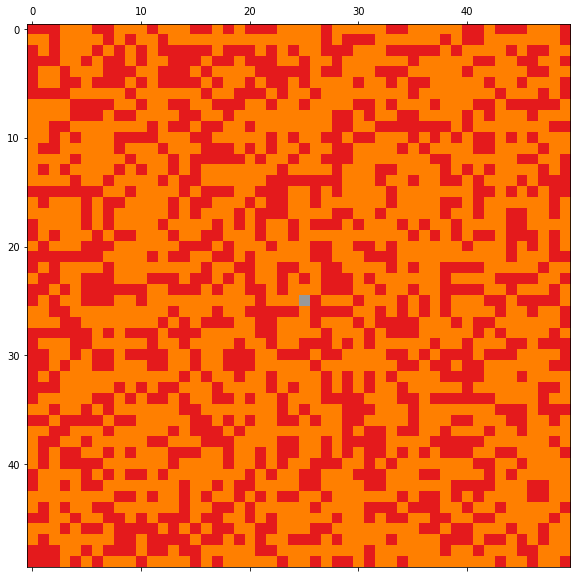

In [27]:
helpers.animate(prediction)

In [33]:
test1 = Testing1(data,model,verbose=1)
test1.run()
test1.plot()

Testing:
state 1/50
[2496    4 2496    0]
state 2/50
[2493    7 2493    0]
state 3/50
[2491    9 2491    0]
state 4/50
[2490   10 2490    0]
state 5/50
[2491    9 2491    0]
state 6/50
[2492    8 2492    0]
state 7/50
[2492    8 2492    0]
state 8/50
[2492    8 2492    0]
state 9/50
[2492    8 2492    0]
state 10/50
[2492    8 2492    0]
state 11/50
[2488   12 2488    0]
state 12/50
[2483   17 2483    0]
state 13/50
[2483   17 2483    0]
state 14/50
[2487   13 2487    0]
state 15/50
[2489   11 2489    0]
state 16/50
[2485   15 2485    0]
state 17/50
[2480   20 2480    0]
state 18/50
[2479   21 2479    1]
state 19/50
[2479   21 2479    2]
state 20/50
[2475   25 2475    0]
state 21/50
[2466   34 2466    2]
state 22/50
[2461   39 2461    1]
state 23/50
[2466   34 2466    1]
state 24/50
[2474   26 2474    1]
state 25/50
[2481   19 2481    1]
state 26/50
[2484   16 2484    2]
state 27/50
[2486   14 2486    0]
state 28/50
[2487   13 2487    0]
state 29/50
[2483   17 2483    0]
state 30/50
[2

TypeError: list indices must be integers or slices, not tuple

In [13]:
visualization = Visualization("2dfire_exp3/18_12_19_09_50_39")

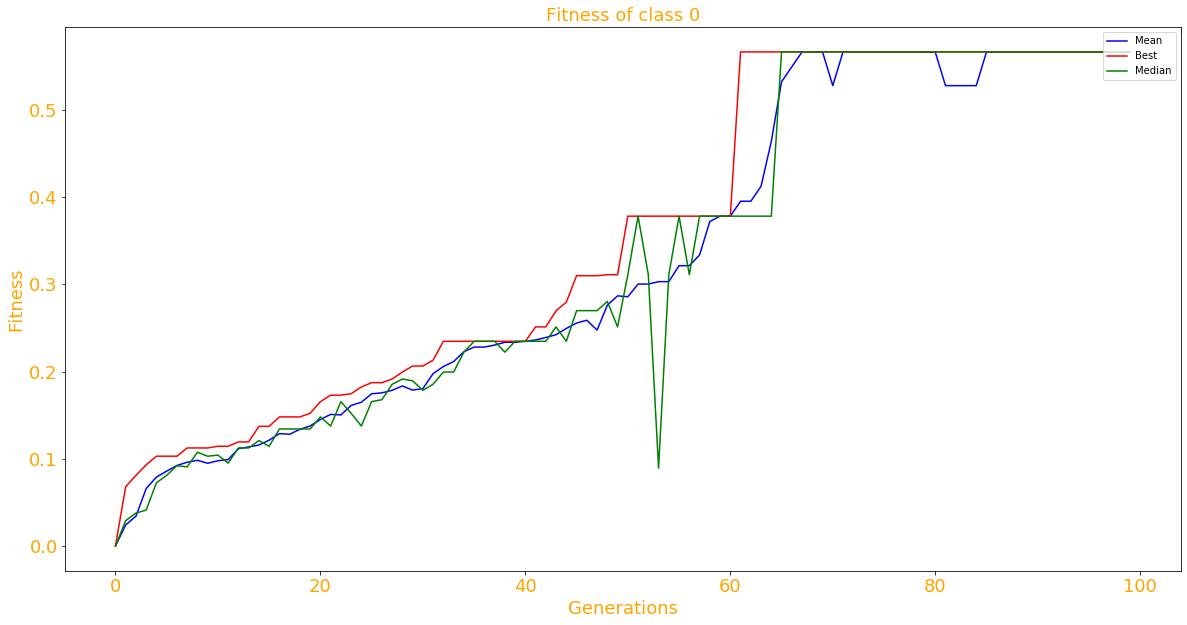

In [14]:
visualization.getFitnessGraph("0")

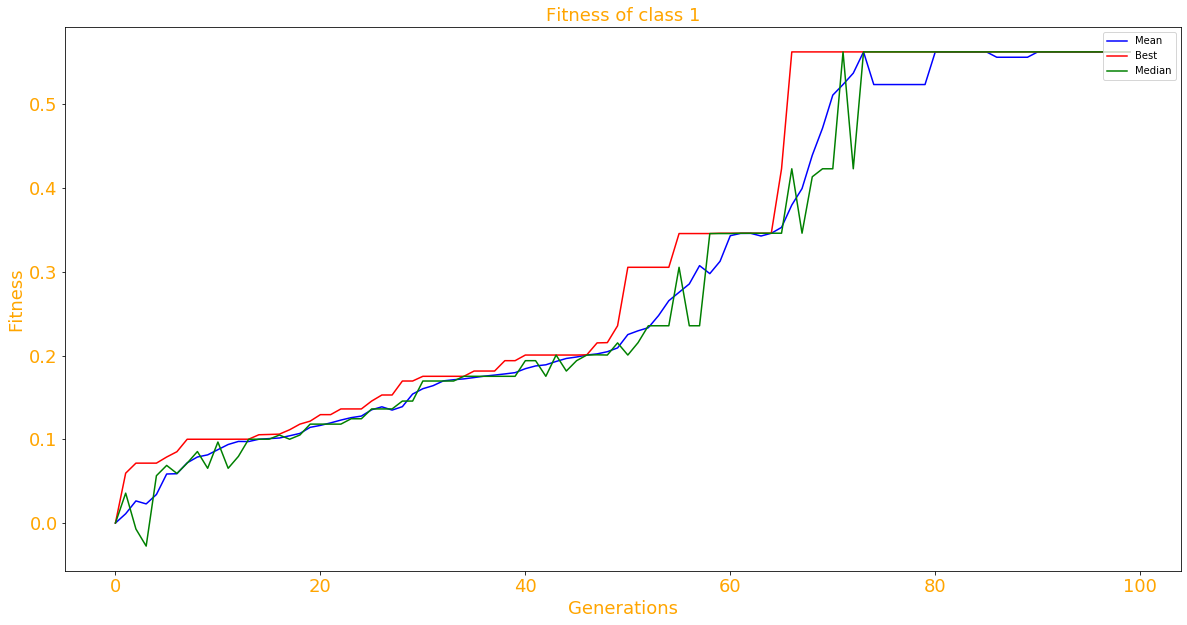

In [15]:
visualization.getFitnessGraph("1")

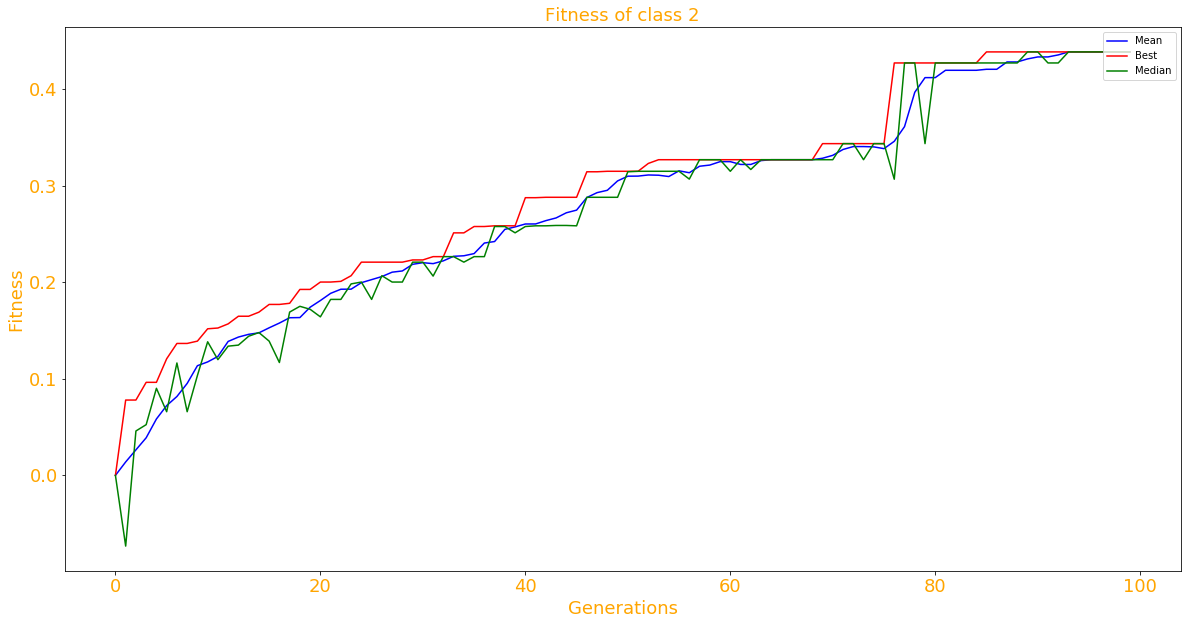

In [16]:
visualization.getFitnessGraph("2")

In [28]:
transformer.lmstr

{0: 'lambda x: (x[12] in {0} if x[12] != -1 else True)',
 1: 'lambda x: (x[12] in {1} if x[12] != -1 else True)',
 2: 'lambda x: (x[11] in {2} if x[11] != -1 else True) and (x[12] in {1} if x[12] != -1 else True) and (x[15] in {0, 2} if x[15] != -1 else True) and (x[17] in {2} if x[17] != -1 else True) and (x[19] in {0, 2} if x[19] != -1 else True) and (x[23] in {0, 2} if x[23] != -1 else True)'}

In [62]:
exp2.world.toDict()

{'generation': 99,
 'populations': [{'generation': 99,
   'goal': '0',
   'chromosomes': [{'uuid': '69864558-f3a0-41fa-b837-91d64974b952',
     'generation': 95,
     'genes': [{'identifier': '0', 'value': 'set()'},
      {'identifier': '1', 'value': 'set()'},
      {'identifier': '2', 'value': 'set()'},
      {'identifier': '3', 'value': '{-1}'},
      {'identifier': '4', 'value': 'set()'},
      {'identifier': '5', 'value': 'set()'},
      {'identifier': '6', 'value': 'set()'},
      {'identifier': '7', 'value': 'set()'},
      {'identifier': '8', 'value': 'set()'},
      {'identifier': '9', 'value': '{0, 2}'},
      {'identifier': '10', 'value': 'set()'},
      {'identifier': '11', 'value': 'set()'},
      {'identifier': '12', 'value': '{0}'},
      {'identifier': '13', 'value': '{-1}'},
      {'identifier': '14', 'value': 'set()'},
      {'identifier': '15', 'value': 'set()'},
      {'identifier': '16', 'value': '{-1}'},
      {'identifier': '17', 'value': '{-1}'},
      {'identifi

In [57]:
import sys
del sys.modules["ExperimentBase"]